In [538]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [539]:
df = pd.read_csv('train.csv')

In [540]:
test_df = pd.read_csv('test.csv')

In [541]:
df.head(5)

,order_time,order_id,order_date,allot_time,accept_time,pickup_time,delivered_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,cancelled_time
0,2021-01-26 02:21:35,556753,2021-01-26 00:00:00,2021-01-26 02:21:59,2021-01-26 02:22:08,2021-01-26 02:32:51,2021-01-26 02:49:47,11696,1.5666,2.65,46.0,46.0,0,0.0,621.0,NaN,NaN,NaN,NaN,NaN
1,2021-01-26 02:33:16,556754,2021-01-26 00:00:00,2021-01-26 02:33:57,2021-01-26 02:34:45,2021-01-26 02:50:25,2021-01-26 03:11:15,18117,2.5207,2.76,8.0,8.0,0,0.0,105.0,NaN,NaN,NaN,3.266667,NaN
2,2021-01-26 02:39:49,556755,2021-01-26 00:00:00,2021-01-26 02:39:57,2021-01-26 02:40:13,2021-01-26 02:56:00,2021-01-26 03:12:46,18623,2.2074,4.80,1.0,1.0,0,0.0,66.0,NaN,NaN,NaN,9.816667,NaN
3,2021-01-26 02:47:53,556756,2021-01-26 00:00:00,2021-01-26 02:48:25,2021-01-26 02:49:06,2021-01-26 03:21:51,2021-01-26 03:41:05,15945,2.1894,6.38,1.0,1.0,0,0.0,127.0,NaN,NaN,NaN,17.533333,NaN
4,2021-01-26 03:06:30,556757,2021-01-26 00:00:00,2021-01-26 03:07:21,2021-01-26 03:07:57,2021-01-26 03:31:38,2021-01-26 04:00:15,17589,2.7870,4.01,34.0,34.0,0,0.0,84.0,NaN,NaN,NaN,1.350000,NaN


In [542]:
df.columns

Index(['order_time', 'order_id', 'order_date', 'allot_time', 'accept_time',
       'pickup_time', 'delivered_time', 'rider_id', 'first_mile_distance',
       'last_mile_distance', 'alloted_orders', 'delivered_orders', 'cancelled',
       'undelivered_orders', 'lifetime_order_count', 'reassignment_method',
       'reassignment_reason', 'reassigned_order', 'session_time',
       'cancelled_time'],
      dtype='object')

In [543]:
len(df.columns)

20

In [544]:
test_df.columns

Index(['order_time', 'order_id', 'order_date', 'allot_time', 'accept_time',
       'rider_id', 'first_mile_distance', 'last_mile_distance',
       'alloted_orders', 'delivered_orders', 'undelivered_orders',
       'lifetime_order_count', 'reassignment_method', 'reassignment_reason',
       'reassigned_order', 'session_time'],
      dtype='object')

In [545]:
len(test_df.columns)

16

In [546]:
df.cancelled.value_counts()

cancelled
0    444782
1      5218
Name: count, dtype: int64

In [547]:
df.isna().sum()

order_time                   0
order_id                     0
order_date                   0
allot_time                   0
accept_time                157
pickup_time               2421
delivered_time            5218
rider_id                     0
first_mile_distance          0
last_mile_distance           0
alloted_orders           16948
delivered_orders         17341
cancelled                    0
undelivered_orders       17341
lifetime_order_count        53
reassignment_method     436256
reassignment_reason     436247
reassigned_order        436247
session_time              3675
cancelled_time          444782
dtype: int64

In [548]:
df.accept_time.isna().sum()

157

In [549]:
test_df.isna().sum()

order_time                   0
order_id                     0
order_date                   0
allot_time                   0
accept_time                 68
rider_id                     0
first_mile_distance          0
last_mile_distance           0
alloted_orders            4773
delivered_orders          4884
undelivered_orders        4884
lifetime_order_count       778
reassignment_method     140212
reassignment_reason     140209
reassigned_order        140209
session_time              5054
dtype: int64

In [550]:
missing_cols = []
for col in df.columns:
    if col not in test_df.columns:
        missing_cols.append(col)

In [551]:
missing_cols

['pickup_time', 'delivered_time', 'cancelled', 'cancelled_time']

In [552]:
Y = df['cancelled']

In [553]:
df.drop(missing_cols,axis=1,inplace=True)

In [554]:
test_df.drop(['order_id','order_date','rider_id',
              'alloted_orders','undelivered_orders',
              'reassignment_method','reassignment_reason',
              'reassigned_order'],axis=1,inplace=True)

In [555]:
test_df.isna().sum()

order_time                 0
allot_time                 0
accept_time               68
first_mile_distance        0
last_mile_distance         0
delivered_orders        4884
lifetime_order_count     778
session_time            5054
dtype: int64

In [556]:
df.drop(['order_id','order_date','rider_id',
              'alloted_orders','undelivered_orders',
              'reassignment_method','reassignment_reason',
              'reassigned_order'],axis=1,inplace=True)

In [557]:
df.isna().sum()

order_time                  0
allot_time                  0
accept_time               157
first_mile_distance         0
last_mile_distance          0
delivered_orders        17341
lifetime_order_count       53
session_time             3675
dtype: int64

In [558]:
df['order_time'] = pd.to_datetime(df['order_time'])
df['allot_time'] = pd.to_datetime(df['allot_time'])
df['accept_time'] = pd.to_datetime(df['accept_time'])


In [559]:
test_df['order_time'] = pd.to_datetime(test_df['order_time'])
test_df['allot_time'] = pd.to_datetime(test_df['allot_time'])
test_df['accept_time'] = pd.to_datetime(test_df['accept_time'])

In [560]:
df['day'] = df['accept_time'].dt.day_name()
test_df['day'] = test_df['accept_time'].dt.day_name()

In [561]:
df['hour'] = df['accept_time'].dt.hour
test_df['hour'] = test_df['accept_time'].dt.hour

In [562]:
df.hour

0          2.0
1          2.0
2          2.0
3          2.0
4          3.0
          ... 
449995    10.0
449996    10.0
449997    10.0
449998    10.0
449999    10.0
Name: hour, Length: 450000, dtype: float64

In [563]:
def func(X):
    if X['day'] == 'Saturday' or X['day'] == 'Sunday':
        return 1
    else:
        return 0 

In [564]:
def func2(a):
    if a == 'Saturday' or a == 'Sunday':
        return 1
    else:
        return 0

In [565]:
# df['points'] = np.where(condition, 5, 0)

In [566]:
df['isWeekend'] = df.apply(func,axis=1)
test_df['isWeekend'] = test_df.apply(lambda x : func2(x['day']),axis=1)

In [567]:
test_df.isWeekend.max()

1

In [568]:
def func_time(X):
    if(X['hour']>6 and X['hour']<=12): return 'Morning'
    elif(X['hour']>12 and X['hour']<=16): return 'Afternoon'
    elif(X['hour']>16 and X['hour']<=19): return 'Evening'
    else: return 'Night'
        

In [569]:
df['whatTime'] = df.apply(func_time,axis=1)
test_df['whatTime'] = test_df.apply(func_time,axis=1)

In [570]:
test_df.whatTime.value_counts()

whatTime
Afternoon    84647
Morning      34294
Evening      19731
Night         6172
Name: count, dtype: int64

In [571]:
df['last_first_mile_ratio'] = df.last_mile_distance / df.first_mile_distance
test_df['last_first_mile_ratio'] = test_df.last_mile_distance / test_df.first_mile_distance

In [572]:
df = pd.get_dummies(df,columns=['whatTime'],dtype='int')
test_df = pd.get_dummies(test_df,columns=['whatTime'],dtype='int')

In [573]:
df['accept_order_time'] = (df['accept_time']-df['order_time']).dt.total_seconds() / 60.0
test_df['accept_order_time'] = (test_df['accept_time']-test_df['order_time']).dt.total_seconds() / 60.0

In [574]:
df['accept_allot_time'] = (df['accept_time']-df['allot_time']).dt.total_seconds() / 60.0
test_df['accept_allot_time'] = (test_df['accept_time']-test_df['allot_time']).dt.total_seconds() / 60.0

In [575]:
df['total_distance'] = df['first_mile_distance'] + df['last_mile_distance']
test_df['total_distance'] = test_df['first_mile_distance'] + test_df['last_mile_distance']


In [576]:
df.drop(['accept_time','allot_time',
         'first_mile_distance','last_mile_distance'],axis=1,inplace=True)

test_df.drop(['accept_time','allot_time',
              'first_mile_distance','last_mile_distance'],axis=1,inplace=True)

In [577]:
df.head(5)

,order_time,delivered_orders,lifetime_order_count,session_time,day,hour,isWeekend,last_first_mile_ratio,whatTime_Afternoon,whatTime_Evening,whatTime_Morning,whatTime_Night,accept_order_time,accept_allot_time,total_distance
0,2021-01-26 02:21:35,46.0,621.0,NaN,Tuesday,2.0,0,1.691561,0,0,0,1,0.550000,0.150000,4.2166
1,2021-01-26 02:33:16,8.0,105.0,3.266667,Tuesday,2.0,0,1.094934,0,0,0,1,1.483333,0.800000,5.2807
2,2021-01-26 02:39:49,1.0,66.0,9.816667,Tuesday,2.0,0,2.174504,0,0,0,1,0.400000,0.266667,7.0074
3,2021-01-26 02:47:53,1.0,127.0,17.533333,Tuesday,2.0,0,2.914040,0,0,0,1,1.216667,0.683333,8.5694
4,2021-01-26 03:06:30,34.0,84.0,1.350000,Tuesday,3.0,0,1.438823,0,0,0,1,1.450000,0.600000,6.7970


In [578]:
df.columns

Index(['order_time', 'delivered_orders', 'lifetime_order_count',
       'session_time', 'day', 'hour', 'isWeekend', 'last_first_mile_ratio',
       'whatTime_Afternoon', 'whatTime_Evening', 'whatTime_Morning',
       'whatTime_Night', 'accept_order_time', 'accept_allot_time',
       'total_distance'],
      dtype='object')

In [579]:
len(df.columns)

15

In [580]:
df.isna().sum()

order_time                   0
delivered_orders         17341
lifetime_order_count        53
session_time              3675
day                        157
hour                       157
isWeekend                    0
last_first_mile_ratio        0
whatTime_Afternoon           0
whatTime_Evening             0
whatTime_Morning             0
whatTime_Night               0
accept_order_time          157
accept_allot_time          157
total_distance               0
dtype: int64

In [581]:
test_df.isna().sum()

order_time                  0
delivered_orders         4884
lifetime_order_count      778
session_time             5054
day                        68
hour                       68
isWeekend                   0
last_first_mile_ratio       0
whatTime_Afternoon          0
whatTime_Evening            0
whatTime_Morning            0
whatTime_Night              0
accept_order_time          68
accept_allot_time          68
total_distance              0
dtype: int64

In [582]:
df['session_time'].fillna(df['session_time'].median(),inplace=True)
test_df['session_time'].fillna(test_df['session_time'].median(),inplace=True)

In [583]:
df['delivered_orders'].fillna(0,inplace=True)
test_df['delivered_orders'].fillna(0,inplace=True)

In [584]:
df['lifetime_order_count'].fillna(1,inplace=True)
test_df['lifetime_order_count'].fillna(1,inplace=True)

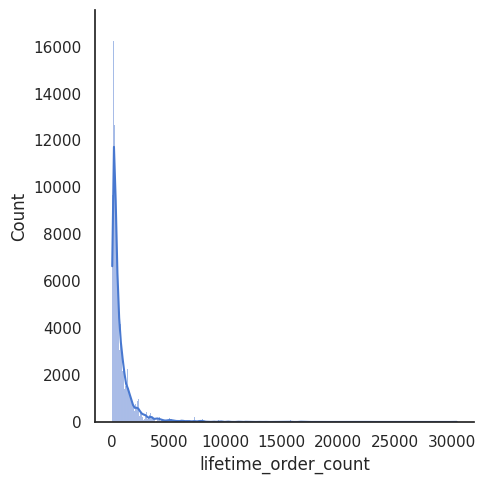

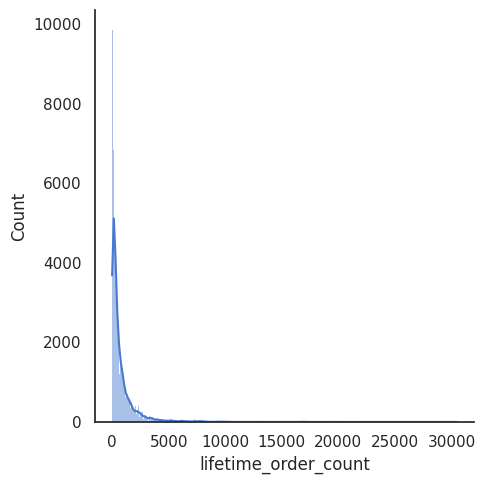

In [585]:
sns.set(color_codes=True)
sns.set(style="white", palette="muted")

for ddf in [df,test_df]:
    sns.displot(ddf['lifetime_order_count'],kde=True)

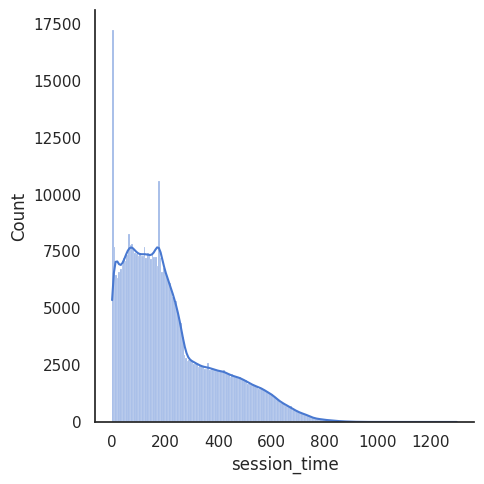

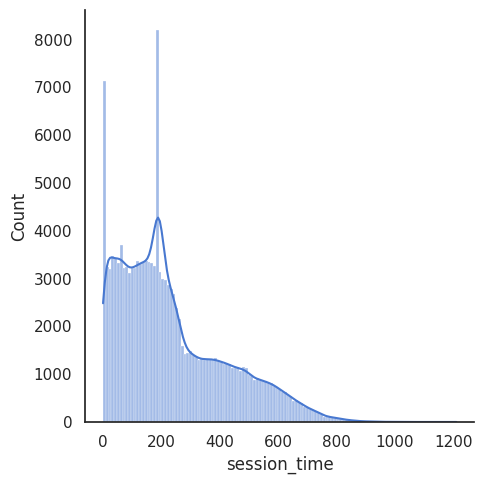

In [586]:
sns.set(color_codes=True)
sns.set(style="white", palette="muted")

for ddf in [df,test_df]:
    sns.displot(ddf['session_time'],kde=True)

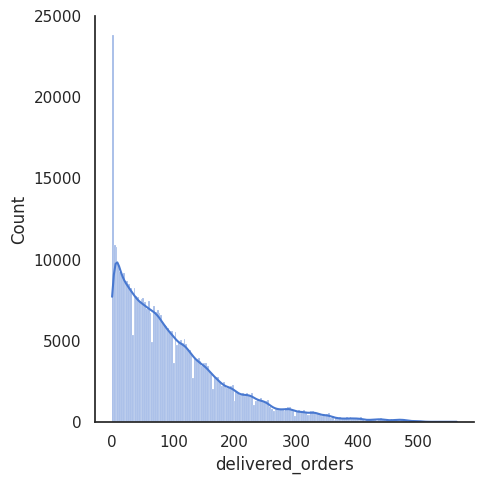

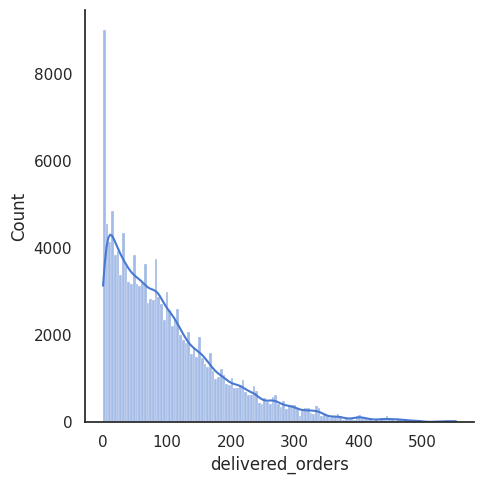

In [587]:
sns.set(color_codes=True)
sns.set(style="white", palette="muted")

for ddf in [df,test_df]:
    sns.displot(ddf['delivered_orders'],kde=True)

In [588]:
df['delivery_ratio'] = df['delivered_orders'] / df['lifetime_order_count']
test_df['delivery_ratio'] = test_df['delivered_orders'] / test_df['lifetime_order_count']

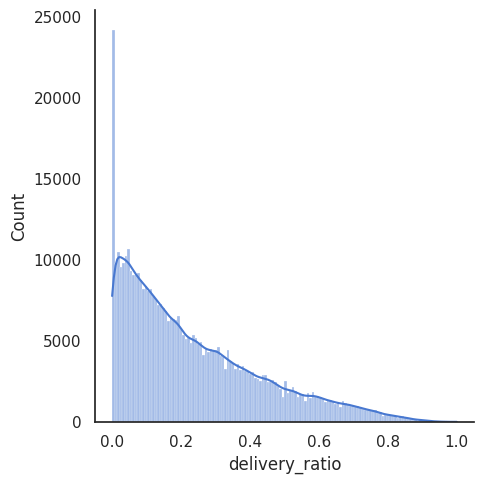

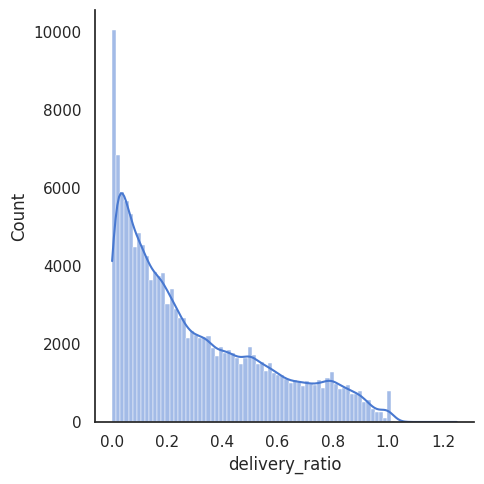

In [589]:
sns.set(color_codes=True)
sns.set(style="white", palette="muted")

for ddf in [df,test_df]:
    sns.displot(ddf['delivery_ratio'],kde=True)

In [590]:
df.isna().sum()

order_time                 0
delivered_orders           0
lifetime_order_count       0
session_time               0
day                      157
hour                     157
isWeekend                  0
last_first_mile_ratio      0
whatTime_Afternoon         0
whatTime_Evening           0
whatTime_Morning           0
whatTime_Night             0
accept_order_time        157
accept_allot_time        157
total_distance             0
delivery_ratio             5
dtype: int64

In [591]:
test_df.isna().sum()

order_time                0
delivered_orders          0
lifetime_order_count      0
session_time              0
day                      68
hour                     68
isWeekend                 0
last_first_mile_ratio     0
whatTime_Afternoon        0
whatTime_Evening          0
whatTime_Morning          0
whatTime_Night            0
accept_order_time        68
accept_allot_time        68
total_distance            0
delivery_ratio           42
dtype: int64

In [592]:
df['accept_order_time'].fillna(df['accept_order_time'].median(),inplace=True)
test_df['accept_order_time'].fillna(test_df['accept_order_time'].median(),inplace=True)

In [593]:
df['accept_allot_time'].fillna(df['accept_allot_time'].median(),inplace=True)
test_df['accept_allot_time'].fillna(test_df['accept_allot_time'].median(),inplace=True)

In [594]:
df.drop(['accept_allot_time','order_time'],axis=1,inplace=True)
test_df.drop(['accept_allot_time','order_time'],axis=1,inplace=True)


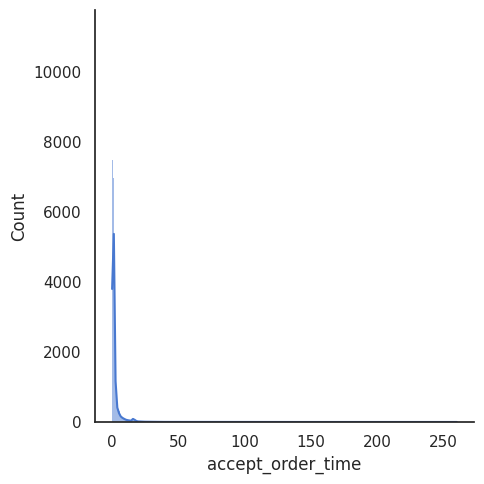

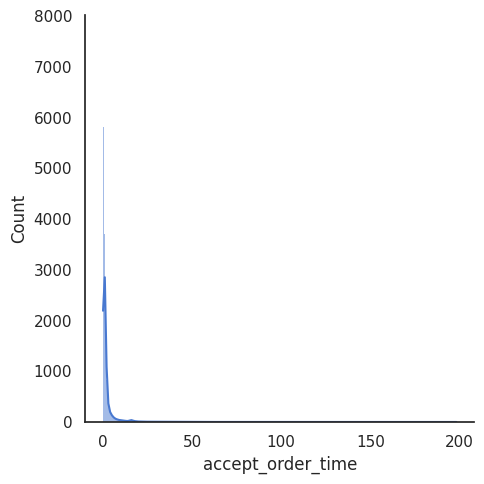

In [595]:
sns.set(color_codes=True)
sns.set(style="white", palette="muted")

for ddf in [df,test_df]:
    sns.displot(ddf['accept_order_time'],kde=True)

In [596]:
df['delivery_ratio'].fillna(0.0,inplace=True)
test_df['delivery_ratio'].fillna(0.0,inplace=True)

In [599]:
test_df.columns

Index(['delivered_orders', 'lifetime_order_count', 'session_time', 'day',
       'hour', 'isWeekend', 'last_first_mile_ratio', 'whatTime_Afternoon',
       'whatTime_Evening', 'whatTime_Morning', 'whatTime_Night',
       'accept_order_time', 'total_distance', 'delivery_ratio'],
      dtype='object')

In [601]:
df.drop(['hour','day'],axis=1,inplace=True)
test_df.drop(['hour','day'],axis=1,inplace=True)

In [602]:
test_df.isna().sum()

delivered_orders         0
lifetime_order_count     0
session_time             0
isWeekend                0
last_first_mile_ratio    0
whatTime_Afternoon       0
whatTime_Evening         0
whatTime_Morning         0
whatTime_Night           0
accept_order_time        0
total_distance           0
delivery_ratio           0
dtype: int64

In [603]:
df.isna().sum()

delivered_orders         0
lifetime_order_count     0
session_time             0
isWeekend                0
last_first_mile_ratio    0
whatTime_Afternoon       0
whatTime_Evening         0
whatTime_Morning         0
whatTime_Night           0
accept_order_time        0
total_distance           0
delivery_ratio           0
dtype: int64

In [604]:
X = df.copy()

In [605]:
X['class_label'] = Y

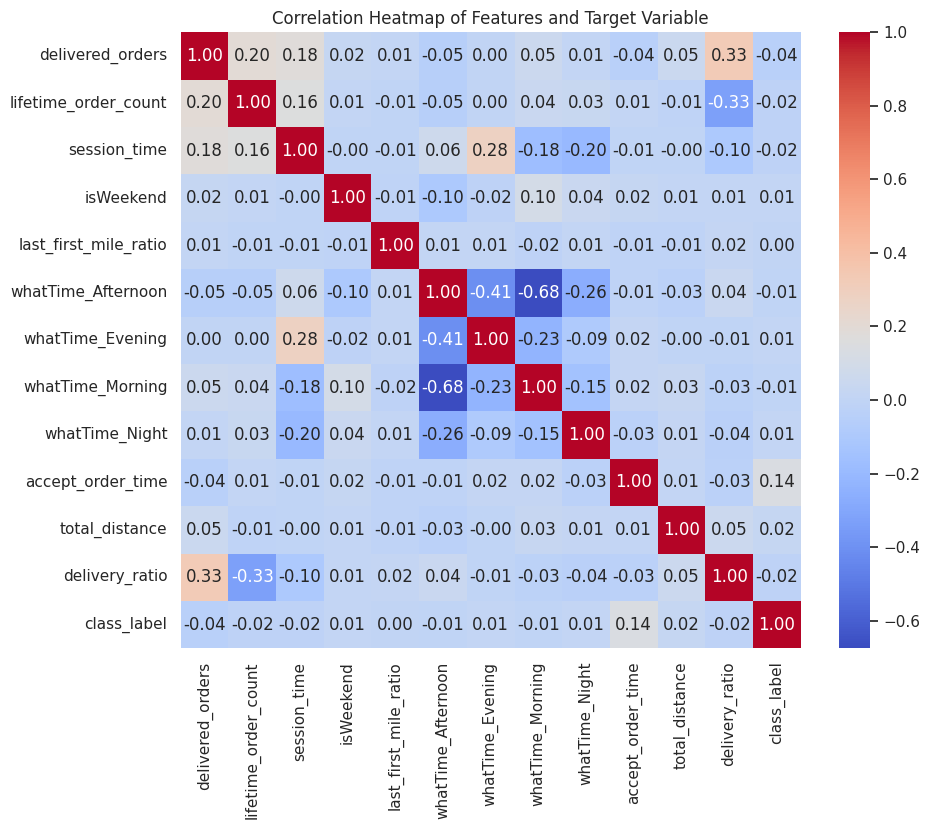

In [606]:
# Calculate the correlation matrix
corr_matrix = X.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features and Target Variable')
plt.show()

In [607]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(df, Y)

In [608]:
X_sm.shape

(889564, 12)

In [609]:
# Initialize XGBoost classifier
clf = XGBClassifier()

# Initialize stratified k-fold cross-validation
k_folds = 5  # Number of folds
skf = StratifiedKFold(n_splits=k_folds)

# Initialize lists to store evaluation results
accuracy_scores = []

# Perform stratified k-fold cross-validation
for train_index, test_index in skf.split(X_sm, y_sm):
    X_train, X_test = X_sm.iloc[train_index], X_sm.iloc[test_index]
    y_train, y_test = y_sm.iloc[train_index], y_sm.iloc[test_index]
    
    # Train XGBoost classifier
    clf.fit(X_train, y_train.values.ravel())
    
    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy and store
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print("accuracy = ",accuracy)

# Calculate mean accuracy
mean_accuracy = np.mean(accuracy_scores)
print("Mean Accuracy:", mean_accuracy)

accuracy =  0.8792555912159313
accuracy =  0.8937964061086037
accuracy =  0.8273088532035321
accuracy =  0.8966180099261999
accuracy =  0.9006475111290976
Mean Accuracy: 0.8795252743166729


In [610]:
submi = pd.read_csv('sample_submission.csv')
y_pred = clf.predict(test_df)
submi['cancelled'].value_counts()
submi['cancelled'] = y_pred
submi['cancelled'].value_counts()
submi.to_csv('submission2.csv',index=False)
submi.head()

,order_id,cancelled
0,130231,0
1,130232,0
2,130233,0
3,130234,0
4,130235,0


In [613]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from mlxtend.classifier import StackingClassifier
from sklearn import ensemble
import seaborn as sns
import xgboost as xgb


In [614]:
clf1 = KNeighborsClassifier()
clf3 = NuSVC(probability=True)
clf4 = xgb.XGBClassifier()
clf5 = DecisionTreeClassifier()
clf7 = AdaBoostClassifier()
clf8 = GradientBoostingClassifier()

In [615]:
classifiers = [clf1,clf3,clf4,clf5,clf7,clf8]

In [617]:
from mlxtend.classifier import StackingCVClassifier


In [618]:
sclf = StackingCVClassifier(classifiers=classifiers, 
                            meta_classifier=clf4)

In [619]:
# Initialize XGBoost classifier

# Initialize stratified k-fold cross-validation
k_folds = 5  # Number of folds
skf = StratifiedKFold(n_splits=k_folds)

# Initialize lists to store evaluation results
accuracy_scores = []

# Perform stratified k-fold cross-validation
for train_index, test_index in skf.split(X_sm, y_sm):
    X_train, X_test = X_sm.iloc[train_index], X_sm.iloc[test_index]
    y_train, y_test = y_sm.iloc[train_index], y_sm.iloc[test_index]
    
    # Train XGBoost classifier
    sclf.fit(X_train, y_train.values.ravel())
    
    # Predict on the test set
    y_pred = sclf.predict(X_test)
    
    # Calculate accuracy and store
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print("accuracy = ",accuracy)

# Calculate mean accuracy
mean_accuracy = np.mean(accuracy_scores)
print("Mean Accuracy:", mean_accuracy)

In [228]:
from sklearn.decomposition import PCA
 
pca = PCA(n_components = 4)
 
X_tr = pca.fit_transform(X_sm)
X_t = pca.transform(test_df)
 
explained_variance = pca.explained_variance_ratio_

In [229]:
X_tr = pd.DataFrame(X_tr)
X_t = pd.DataFrame(X_t)


In [230]:
explained_variance

array([9.80857288e-01, 1.56649053e-02, 3.40734830e-03, 6.81656074e-05])

In [231]:
# Initialize XGBoost classifier
clf = XGBClassifier()

# Initialize stratified k-fold cross-validation
k_folds = 5  # Number of folds
skf = StratifiedKFold(n_splits=k_folds)

# Initialize lists to store evaluation results
accuracy_scores = []

# Perform stratified k-fold cross-validation
for train_index, test_index in skf.split(X_tr, y_sm):
    X_train, X_test = X_tr.iloc[train_index], X_tr.iloc[test_index]
    y_train, y_test = y_sm.iloc[train_index], y_sm.iloc[test_index]
    
    # Train XGBoost classifier
    clf.fit(X_train, y_train.values.ravel())
    
    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy and store
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print("accuracy = ",accuracy)

# Calculate mean accuracy
mean_accuracy = np.mean(accuracy_scores)
print("Mean Accuracy:", mean_accuracy)

accuracy =  0.7461793123605358
accuracy =  0.7381866417855918
accuracy =  0.7622321022072586
accuracy =  0.7545148471443908
accuracy =  0.7463352668735105
Mean Accuracy: 0.7494896340742575


In [233]:
submi = pd.read_csv('sample_submission.csv')
y_pred = clf.predict(X_t)
submi['cancelled'].value_counts()
submi['cancelled'] = y_pred
submi['cancelled'].value_counts()
submi.to_csv('submission3.csv',index=False)
submi.head()

,order_id,cancelled
0,130231,0
1,130232,0
2,130233,0
3,130234,0
4,130235,0


In [237]:
from imblearn.under_sampling import RandomUnderSampler

ran=RandomUnderSampler() ##intialize to return indices of dropped rows
X_rs,y_rs = ran.fit_resample(df,Y)

In [238]:
X_rs.shape

(10436, 6)

In [239]:
# Initialize XGBoost classifier
clf = XGBClassifier()

# Initialize stratified k-fold cross-validation
k_folds = 5  # Number of folds
skf = StratifiedKFold(n_splits=k_folds)

# Initialize lists to store evaluation results
accuracy_scores = []

# Perform stratified k-fold cross-validation
for train_index, test_index in skf.split(X_rs, y_rs):
    X_train, X_test = X_rs.iloc[train_index], X_rs.iloc[test_index]
    y_train, y_test = y_rs.iloc[train_index], y_rs.iloc[test_index]
    
    # Train XGBoost classifier
    clf.fit(X_train, y_train.values.ravel())
    
    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy and store
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print("accuracy = ",accuracy)

# Calculate mean accuracy
mean_accuracy = np.mean(accuracy_scores)
print("Mean Accuracy:", mean_accuracy)

accuracy =  0.6652298850574713
accuracy =  0.6602779108768567
accuracy =  0.6468615237182559
accuracy =  0.639195016770484
accuracy =  0.6511739338763776
Mean Accuracy: 0.6525476540598891


In [240]:
submi = pd.read_csv('sample_submission.csv')
y_pred = clf.predict(test_df)
submi['cancelled'].value_counts()
submi['cancelled'] = y_pred
submi['cancelled'].value_counts()
submi.to_csv('submission4.csv',index=False)
submi.head()

,order_id,cancelled
0,130231,0
1,130232,1
2,130233,0
3,130234,0
4,130235,0


In [ ]:
df = df.drop(['cancelled','order_id','rider_id',
            'cancelled_time','reassignment_method',
            'reassignment_reason','reassigned_order','order_date'],axis=1)

In [ ]:
px.bar(Y.value_counts())

In [ ]:
len(df)

In [ ]:
df.iloc[0][0]

In [ ]:
df['order_time'] = pd.to_datetime(df['order_time'])
df['allot_time'] = pd.to_datetime(df['allot_time'])
df['accept_time'] = pd.to_datetime(df['accept_time'])
df['pickup_time'] = pd.to_datetime(df['pickup_time'])
df['delivered_time'] = pd.to_datetime(df['delivered_time'])

In [ ]:
df['allot_order_seconds'] = (df['allot_time'] - df['order_time']).dt.total_seconds() / 60.0
df['accept_allot_seconds'] = (df['accept_time'] - df['allot_time']).dt.total_seconds() / 60.0
df['pickup_order_seconds'] = (df['pickup_time'] - df['order_time']).dt.total_seconds() / 60.0
df['delivered_order_seconds'] = (df['delivered_time'] - df['order_time']).dt.total_seconds() / 60.0
df['delivered_pickup_seconds'] = (df['delivered_time'] - df['pickup_time']).dt.total_seconds() / 60.0
df['pickup_accept_seconds'] = (df['pickup_time'] - df['accept_time']).dt.total_seconds() / 60.0

In [ ]:
df.drop(['order_time', 'allot_time', 'accept_time',
       'pickup_time', 'delivered_time'],axis=1,inplace=True)

In [ ]:
df['delivered_order_seconds']

In [ ]:
df.columns

In [ ]:
null_index = np.where(df['session_time'].isnull() == True)[0]

In [ ]:
len(np.where(df['session_time'].isnull() == True)[0])

In [ ]:
selected_rows = df['session_time'][~df['session_time'].isnull()]
print(len(selected_rows))

In [ ]:
# Find the mean
mean = selected_rows.mean()

# Find the median
median = selected_rows.median()

# Find the mode
mode = selected_rows.mode()

# Print the results
print("Mean:", mean)
print("Median:", median)
print("Mode:", mode)

In [ ]:
df['undelivered_orders'].median()

In [ ]:
r = df['undelivered_orders'][~df['undelivered_orders'].isnull()]        
r.value_counts()

In [ ]:
r = df['delivered_orders'][~df['delivered_orders'].isnull()]        
r.value_counts()

In [ ]:
r = df['alloted_orders'][~df['alloted_orders'].isnull()]        
r.value_counts()

In [ ]:
df['session_time'].fillna(df['session_time'].median(),inplace=True)

In [ ]:
df['delivered_orders'].fillna(df['delivered_orders'].median(),inplace=True)

In [ ]:
df['lifetime_order_count'].fillna(df['lifetime_order_count'].median(),inplace=True)

In [ ]:
df['delivered_orders'].isna().sum()

In [ ]:
df['session_time'].isna().sum()

In [ ]:
# Plot the histogram
selected_rows.plot.hist(bins=50)

# # Display the plot
# plt.show()

In [ ]:
df['session_time'].plot.hist(bins=50)

In [ ]:
df['delivered_order_seconds'].plot.hist(bins=5000)

In [ ]:
boxplot = df.boxplot(column=['delivered_order_seconds'])

In [ ]:
med = df['delivered_order_seconds'].median()
print(med)

In [ ]:
df.loc[df['delivered_order_seconds']>90,'delivered_order_seconds'] = df['delivered_order_seconds'].median()
df['delivered_order_seconds'].fillna(df['delivered_order_seconds'].median(),inplace=True)
#df['delivered_order_seconds'].apply(lambda x: med if x>50 else x)
df['delivered_order_seconds'].plot.hist(bins=50)

In [ ]:
df['delivered_pickup_seconds'].plot.hist(bins=50)

In [ ]:
df['delivered_pickup_seconds'].median()

In [ ]:
df.loc[df['delivered_pickup_seconds']>50,'delivered_pickup_seconds'] = df['delivered_pickup_seconds'].median()
df['delivered_pickup_seconds'].fillna(df['delivered_pickup_seconds'].median(),inplace=True)


In [ ]:
df['delivered_pickup_seconds'].plot.hist(bins=50)

In [ ]:
df['pickup_accept_seconds'].plot.hist(bins=50)

In [ ]:
df['pickup_accept_seconds'].median()

In [ ]:
df.loc[df['pickup_accept_seconds']>50,'pickup_accept_seconds'] = df['pickup_accept_seconds'].median()

In [ ]:
df.loc[df['pickup_accept_seconds']<0,'pickup_accept_seconds'] = 0

In [ ]:
df['pickup_accept_seconds'].fillna(df['pickup_accept_seconds'].median(),inplace=True)

In [ ]:
df['pickup_accept_seconds'].plot.hist(bins=50)

In [ ]:
df.isna().sum()

In [ ]:
df['total_dist'] = df['first_mile_distance'] + df['last_mile_distance']

In [ ]:
df.drop(['accept_allot_seconds',
     'pickup_order_seconds','allot_order_seconds',
 'alloted_orders','undelivered_orders',
 'first_mile_distance','last_mile_distance'],axis=1,inplace=True)

In [ ]:
df.isna().sum()

In [ ]:
# Initialize XGBoost classifier
clf = XGBClassifier()

# Initialize stratified k-fold cross-validation
k_folds = 5  # Number of folds
skf = StratifiedKFold(n_splits=k_folds)

# Initialize lists to store evaluation results
accuracy_scores = []

# Perform stratified k-fold cross-validation
for train_index, test_index in skf.split(df, Y):
    X_train, X_test = df.iloc[train_index], df.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    # Train XGBoost classifier
    clf.fit(X_train, y_train.values.ravel())
    
    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy and store
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print("accuracy = ",accuracy)

# Calculate mean accuracy
mean_accuracy = np.mean(accuracy_scores)
print("Mean Accuracy:", mean_accuracy)

In [ ]:
from imblearn.over_sampling import SMOTE


In [ ]:
X = df.copy()

In [ ]:
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, Y)

In [ ]:
import seaborn as sns


In [ ]:
px.bar(y_sm.value_counts())

In [ ]:
ddf = X_sm.copy()
ddf['y'] = y_sm

# Calculate the correlation matrix
corr_matrix = ddf.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features and Target Variable')
plt.show()

In [ ]:
# Initialize XGBoost classifier
clf = XGBClassifier()

# Initialize stratified k-fold cross-validation
k_folds = 5  # Number of folds
skf = StratifiedKFold(n_splits=k_folds)

# Initialize lists to store evaluation results
accuracy_scores = []

# Perform stratified k-fold cross-validation
for train_index, test_index in skf.split(X_sm, y_sm):
    X_train, X_test = X_sm.iloc[train_index], X_sm.iloc[test_index]
    y_train, y_test = y_sm.iloc[train_index], y_sm.iloc[test_index]
    
    # Train XGBoost classifier
    clf.fit(X_train, y_train.values.ravel())
    
    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy and store
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print("accuracy = ",accuracy)

# Calculate mean accuracy
mean_accuracy = np.mean(accuracy_scores)
print("Mean Accuracy:", mean_accuracy)

In [ ]:
print("Year = ",t.dt.year)

In [ ]:
print(t[0])

In [ ]:
print("Year = ",t[0].year)
print("month = ",t[0].month)
print("day = ",t[0].day)
print("hour = ",t[0].hour)
print("minutes = ",t[0].minute)
print("seconds = ",t[0].second)

In [ ]:
(t[1] - t[0])

In [ ]:
(t[1] - t[0]).total_seconds() / 60.0

In [ ]:
(pd.Timedelta(t[1] - t[0]) / pd.Timedelta(minutes=1))

In [ ]:
df.describe()